In [ ]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10, sqrt, cos, pi
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Importing Tweet Data
***

In [ ]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [ ]:
tweet_full.count()

In [ ]:
tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
           (tweet_full.index <= '2017-09-12 23:59:59')].info()

In [ ]:
len(tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
               (tweet_full.index <= '2017-09-12 23:59:59')].user_id.unique())

In [ ]:
tweet_paper = tweet_full[(tweet_full.index >= '2017-09-10 00:00:00')&
           (tweet_full.index <= '2017-09-12 23:59:59')]

In [ ]:
len(tweet_paper[tweet_paper.tweet_coords.isnull()])

In [ ]:
len(tweet_paper[tweet_paper.tweet_coords_list.isnull()])

In [ ]:
len(tweet_paper[tweet_paper.tweet_long.isnull()])

In [ ]:
tweet_paper[tweet_paper.tweet_coords.notnull()].head(1)

In [ ]:
print(tweet_paper.tweet_long.max())
print(tweet_paper.tweet_long.min())
print(tweet_paper.tweet_lat.max())
print(tweet_paper.tweet_lat.min())

In [ ]:
tweet_full[tweet_full.enc_url.notnull()]

In [ ]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [ ]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [ ]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [ ]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

In [ ]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

In [ ]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [ ]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

In [ ]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

## Word/Token Statistics
***

In [ ]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [ ]:
word_counts.size

In [ ]:
word_counts.head(20)

In [ ]:
word_counts.tail(20)

In [ ]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [ ]:
word_counts_reduce.size

In [ ]:
# np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

In [ ]:
word_counts_reduce.head(20)

In [ ]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [ ]:
# word_counts_full_tokenizer.size

In [ ]:
# word_counts_full_tokenizer.head(20)

In [ ]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [ ]:
ex_text = "OOOOMMMMGGGGG This is the #1 worst THING HAPPENING IN 2017!!!!!! Power is out & Basement is flooded! #irma #hurricane @TV9 @my_friend https;//my.domain.net"

In [ ]:
tweet_test = ex_text
print(tweet_test)
tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
print(tweet_test.split())
i=0
print(f"S: {tweet_test}");i+=1
#     1: remove URLs:
tweet_test = re.sub('https?://\S+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     2: remove @mentions, including those with a leading '-' or '.' : 
tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     3: remove punctuation, but not hashtags:
tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
print(f"{i}: {tweet_test}");i+=1
#     4: remove non-hashtag '#'.
# tweet_test = re.sub('#\B','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     6: drop words of < 4 characters, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1
#     7: drop numbers, but not hashtags
tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
print(reduce_lengthening(ex_text))

In [ ]:
print(tokens_no_stopwords(ex_text))

In [ ]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

In [ ]:
tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

In [ ]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [ ]:
word_counts_full_token_clean.size

In [ ]:
word_counts_full_token_clean.head(20)

In [ ]:
word_counts_full_token_clean.tail(20)

In [ ]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [ ]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [ ]:
tweet_len_post[tweet_len_post.index <= 10].sum()

In [ ]:
tweet_len_post.sum()

In [ ]:
tweet_len

In [ ]:
tweet_len_post

In [ ]:
tweet_len_post[tweet_len_post.index < 11].sum()

In [ ]:
# tweet_len_post[tweet_len_post.index < 11].sum()/tweet_len_post.sum()

In [ ]:
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:
fig_tweet_hist = plt.figure(figsize=(16,8))
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
#fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [ ]:
search_term = 'irma'

### Window Size: 1-10

In [ ]:
# # comparison_type = "Min. Word Freq."
# # comparison_short = "MinWordFreq"
# comparison_type = "Window Size"
# comparison_short = "WindowSize"

In [ ]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((12)))

In [ ]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(0,11):
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
#     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, min_count=i)#, window=8, workers=1, size=100, negative=i)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Comparison Functions

Need a way to write the comparison functions with a larger function that calls them.

how about writing the functions as separate, with a larger function that calls the smaller functions with an argument.

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [ ]:
def meanCosSim(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [ ]:
def sumCosSimSqrtSum(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [ ]:
def dotProductOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [ ]:
def cosSimOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if ((len(tweet_as_terms) > 0) & (np.all(score_matrix != np.zeros(vector_dim,)))):
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [ ]:
def scalarFunctions(tweet,vector_set,formula='dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet,vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet,vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet,vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet,vector_set)
    else:
        return np.NaN

In [ ]:
# scalarFunctions(tweets_on_date.iloc[0,1],vectors_series[1],'mcs')

In [ ]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [ ]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [ ]:
# func_type = "Dot Product of Tweet Vector and Search Term"
# func_short = "DotProduct"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the dot product of the score vector, and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [ ]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [ ]:
# tweet_encoded.iloc[0:5].tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[1],'mcs'))

In [ ]:
# for i in range(0,11):
# #     create strings for column heads
#     sw = f'score_window_{i}'
#     mmsw = f'MM_{sw}'
    
# #     Scoring tweets in this column:
#     tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'dp'))
                                                       
# #     column of scores for this iteration
#     tweet_scores = tweet_encoded[sw]

# #     calculating Min Max Scaling for this column 
#     tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
# vectors_series.iloc[1].wv.similar_by_word("irma", topn=10, restrict_vocab=None)

In [ ]:
# for i in range(0,11):
#     print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),5))

In [ ]:
# fig_0 = plt.figure(figsize=(16,8),facecolor='w')

# for j in range(1,11):
#     window_label = f"{comparison_type}: {j}"
#     plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("Percent of Tweets at or above Threshold")
# plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
# plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
# f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
# pre_score_df = pd.DataFrame(np.zeros((101,11)))
# rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
# for i in range(1,11):
#     for j in range(101):
#         f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
# print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
# print(f1_window_score_df.idxmax().max())
# print(f1_window_score_df.max().max())

In [ ]:
# fig_1 = plt.figure(figsize=(16,8),facecolor='w')
# for i in range(1,11):
#     plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
# plt.xlabel("Min-Max Scaled Tweet Score Threshold")
# plt.ylabel("F1 Score of Tweets Above Threshold")
# plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
# plt.legend();
# # fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [ ]:
# comparison_type = "Hidden Layer Dimensionality"
# comparison_short = "HLD"

In [ ]:
# # eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
# vectors_series = pd.Series(np.zeros((11)))

In [ ]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(1,11):
#     hidden_layer_dim = 50*i
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size 8, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
#     vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=hidden_layer_dim, seed=1, sg=1, negative=5)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

## 2min 29s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
## 6.67 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)
## 16.1 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [ ]:
# taking values from iterative test
HD=150
MWC=5
WWS=1
NS=1
EP=25
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)

In [ ]:
mt3_tweet = "check out what the storm did last night!"
scalarFunctions(mt3_tweet,opt_vector_model,'dp')

In [ ]:
# opt_vector_model.wv.get_vector('irma')

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

def_vector_model = Word2Vec(tweets_tokens, seed=1, sg=1)
    
# train the model over 10 epochs
#def_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

### AU-ROC Score

In [ ]:
# default parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'd-sw-{i}'
    mmsw = f'MM-{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(def_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
# Optimal parameters for Word2Vec:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'o-sw-{i}'
    mmsw = f'MM-{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(opt_vector_model,i))
                                                       
#     column of scores for this iteration|
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
tweet_encoded.columns

In [ ]:
opt_vector_model.wv.similarity('irma','storm')

In [ ]:
tweet_encoded[(tweet_encoded['o-sw-dp']>7.72) & (tweet_encoded['o-sw-dp']<7.73)]

In [ ]:
# tweet_encoded[['tweet_id','timestamp','irma_rel','tweet','sw_dp','MM_sw_dp']].to_csv(r'./190930_wordScores.csv')

In [8]:
print(tweet_encoded['MM-o-sw-dp'].mean())
print(tweet_encoded['MM-o-sw-dp'].median())
print(tweet_encoded['MM-o-sw-dp'].std())

23.342124875758813
20.355846947168168
13.908999147132262


In [ ]:
# pickle.dump(tweet_encoded,open('20200204_DataForPaper.pkl','wb'))

In [6]:
tweet_encoded = pickle.load(open('20200204_DataForPaper.pkl','rb'))

Graphs for Paper

In [2]:
import seaborn as sns

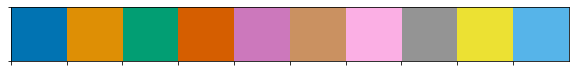

In [3]:
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

In [17]:
for i in ['dp','mcs','scssc','cstvs']:
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM-o-sw-{i}']),3))

0.884
0.733
0.833
0.799


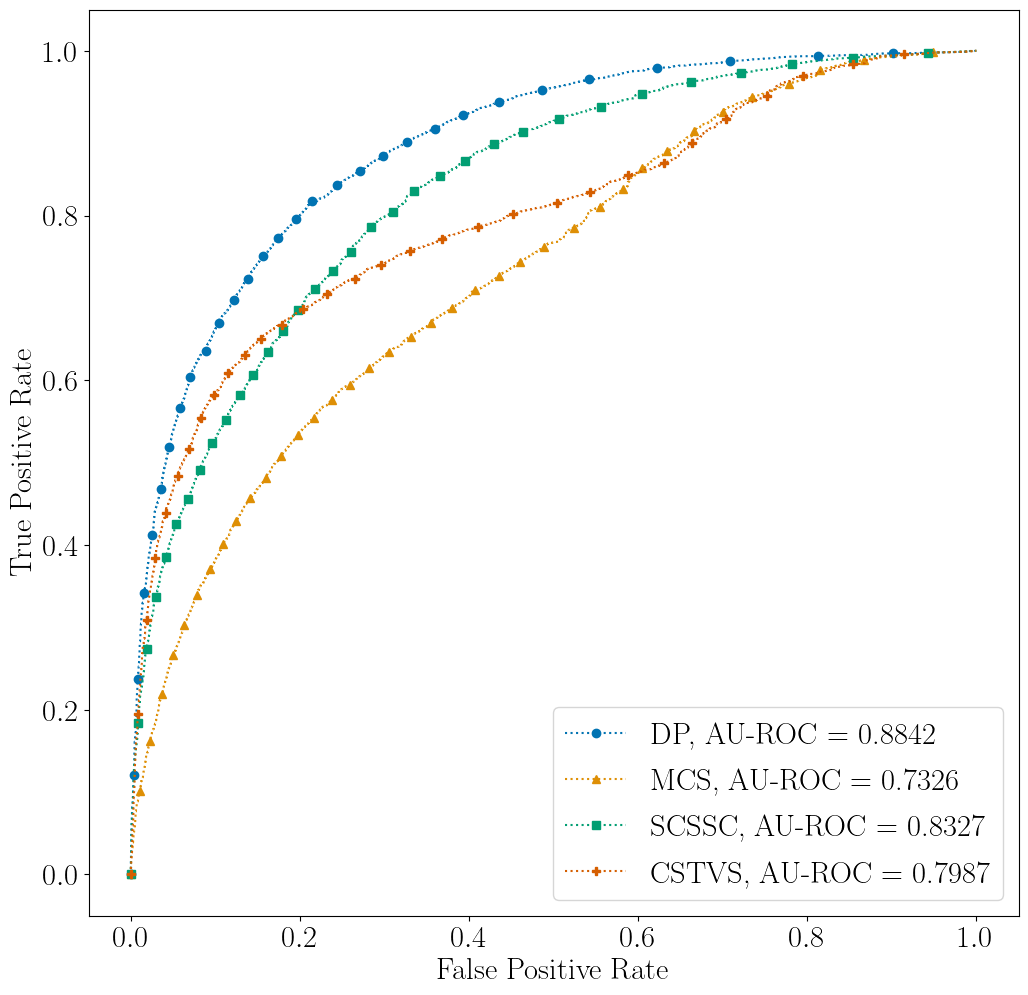

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
sns.set_palette('colorblind')
fig_roc_s = plt.figure(figsize=(12, 12), dpi=100, facecolor='w')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# color_list = {'dp':"#2364AA",'mcs':"#3DA5D9",'scssc':"#73BFB8",'cstvs':"#FEC601",'mid':"#EA7317"}
line_list = {'d':":",'o':":"}
marker_list = {'dp':'o','mcs':'^','scssc':'s','cstvs':'P'}

for i in ['dp','mcs','scssc','cstvs']:
#     for j in ['d','o']:
    for j in ['o']:
        
        fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM-{j}-sw-{i}'])
        auroc_score = round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM-o-sw-{i}']),4)
        label_text = f"{i.upper()}, AU-ROC = {auroc_score}"
#         label_text = i.upper()+"("+j.upper()+")"
#         plt.plot(fpr,tpr,label=label_text,linestyle=line_list.get(j),color=color_list.get(i))
        plt.plot(fpr,tpr,label=label_text,linestyle=":",marker=marker_list.get(i),markevery=200)
# plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold",color=color_list.get('mid'))

# plt.title("AU-ROC of Scalar Formulas")
plt.legend(loc="lower right")
plt.show()
fig_roc_s.savefig('./figures/text_auroc_paper.eps',format='eps',bbox_inches='tight')

In [ ]:
tweet_times = tweet_encoded.set_index('timestamp')

In [ ]:
tweet_times['oSWDPStd'] = (tweet_times['o-sw-dp'] - tweet_times['o-sw-dp'].mean())/tweet_times['o-sw-dp'].std()

In [ ]:
tweet_times['oSWDPStdMM'] = ((tweet_times['oSWDPStd'] - tweet_times['oSWDPStd'].min())* 100) / (tweet_times['oSWDPStd'].max() - tweet_times['oSWDPStd'].min())

In [ ]:
tweet_times['MMoDPNormStd']  = (tweet_times['MM-o-sw-dp'] - tweet_times['MM-o-sw-dp'].mean())/tweet_times['MM-o-sw-dp'].std()

In [ ]:
np.all(tweet_times['oSWDPStdMM'] == tweet_times['MM-o-sw-dp'])

In [ ]:
tweet_times[tweet_times['oSWDPStdMM'] != tweet_times['MM-o-sw-dp']]

In [ ]:
tweet_times[['oSWDPStd','oSWDPStdMM','MMoDPNormStd','MM-o-sw-dp']].head()

In [ ]:
tweet_times.groupby(tweet_times.index.hour).count()['tweet']

In [ ]:
tweet_times['oSWDPStd'].std()

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot()


# sns.stripplot(x=tweet_times.index.hour,y=tweet_times['MMoDPNormStd'],jitter=.35,palette='viridis',alpha=.5)
sns.boxplot(x=tweet_times.index.hour,y=tweet_times['oSWDPStdMM'],color='lightblue')

ax1.set_xlabel('Hour of day in GMT')
ax1.set_ylabel('MinMax Score of Tweets')
ax1.set_title('Distribution of Tweet Score by Hour')
ax2 = ax1.twinx()
ax2.plot(tweet_times.groupby(tweet_times.index.hour).count()['tweet'],label='Tweet Count')
ax2.set_ylabel('Count of Tweets per Hour')
ax2.axvline(x=13,label='Landfall Time',linestyle=':',color='black')
ax2.grid(b=False)
ax2.legend()
plt.show()
fig.savefig(f'./figures/boxplot.pdf',bbox_inches='tight')

In [ ]:
tweet_times.index.hour

## Optimized Loops

In [ ]:
[10,25,50,100,125,250,500]

In [ ]:
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')
# tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]
# tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)
# search_term = 'irma'
# # Hidden Layer Dimensions (hld)
# # Minimum Word Count (mwc)
# # Word Window Size (wws)
# # Negative Sampling (ns)
# # Epochs (ep)
# # Scoring formulas (sf)

In [ ]:
# roc_df = pd.DataFrame()
# for hld in range(50,501,50):
#     for mwc in range(10):
#         for wws in range(1,11):
#             for ns in range(10):
#                 for ep in [10,25,50,100,125,250,500]:
#                     vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, workers=1,
#                                             size = hld,
#                                             min_count = mwc,
#                                             window = wws,
#                                             negative = ns)
#                     vector_model.train(tweets_tokens,
#                                        total_examples = len(tweet_text),
#                                        epochs=ep)
#                     for sf in ['dp','mcs','scssc','cstvs']:
# #                         score tweets
#                         tweet_encoded['score'] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vector_model,sf))
# #                         convert to min-max
#                         tweet_scores = tweet_encoded['score']
#                         tweet_encoded['mm'] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())
# #                         get AU-ROC
#                         roc_row_score = roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['mm'])
# #                         add to DataFrame
#                         roc_row = pd.DataFrame([roc_row_score,hld,mwc,wwc,ns,ep,sf]).T
#                         roc_df = roc_df.append(roc_row, ignore_index=True)
# #                         roc_df = pd.concat([roc_df,roc_row.T],axis=0)
#                         roc_row

In [ ]:
# roc_df.to_csv('./optimal.csv')

In [ ]:
# roc_df.rename(columns={0:'AUROC',1:'HLD',2:'MWC',3:'WWS',4:'NS',5:'EP',6:'SF'}).sort_values('AUROC',ascending=False)

In [ ]:
# roc_df.loc[14032]

In [10]:
tweet_encoded.columns

Index(['index', 'irma_rel', 'tweet', 'timestamp', 'tweet_id', 'tweet_text',
       'user_id', 'tweet_coords', 'tweet_coords_list', 'tweet_long',
       'tweet_lat', 'location', 'enc_url', 'tweet_lang', 'hashtags', 'd-sw-dp',
       'MM-d-sw-dp', 'd-sw-mcs', 'MM-d-sw-mcs', 'd-sw-scssc', 'MM-d-sw-scssc',
       'd-sw-cstvs', 'MM-d-sw-cstvs', 'o-sw-dp', 'MM-o-sw-dp', 'o-sw-mcs',
       'MM-o-sw-mcs', 'o-sw-scssc', 'MM-o-sw-scssc', 'o-sw-cstvs',
       'MM-o-sw-cstvs'],
      dtype='object')

In [12]:
for i in ['dp','mcs','scssc','cstvs']:
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM-o-sw-{i}']),4))

0.8842
0.7326
0.8327
0.7987


### Saed's tweets:

In [ ]:
# s_tweets = pd.read_csv(r'./irma_3days_tweets.csv')

In [ ]:
# s_tweets.head(5)

In [ ]:
# s_tweets_tokens = s_tweets['text'].apply(tokens_no_stopwords)
# s_tweets_v_model = Word2Vec(s_tweets_tokens,
#                            min_count=MWC,
#                            window = WWS,
#                            workers=1,
#                            size=HD,
#                            seed=1,
#                            sg=1,
#                            negative = NS)
# s_tweets_v_model.train(s_tweets_tokens, total_examples = len(s_tweets['text']), epochs=EP)

In [ ]:
# s_tweets['dp_score'] = s_tweets['text'].apply(scalarFunctions,args=(opt_vector_model,'dp'))
# s_tweets_scores = s_tweets['dp_score']
# s_tweets['mm_dp_score'] = ((s_tweets_scores - s_tweets_scores.min())* 100) / (s_tweets_scores.max() - s_tweets_scores.min())

In [ ]:
# s_tweets.to_csv(r'./irma_3days_tweets_scored.csv')

In [ ]:
# s_tweets.sort_values('mm_dp_score',ascending=False)

### Related Words by 1 Hour Increments

In [ ]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("1HR")
end_date = pd.to_datetime("2017-09-11 00:00:00")
top_num_words = 20
search_term = 'irma'

In [ ]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    opt_vector_model_1hr = Word2Vec(tweets_tokens, min_count=MWC, window=WWS, workers=1, size=HD, seed=1, sg=1, negative=NS)
    opt_vector_model_1hr.train(tweets_tokens, total_examples=len(tweet_text), epochs=EP)
    opt_word_matrix_1hr = opt_vector_model_1hr.wv[opt_vector_model_1hr.wv.vocab]
    terms_from_range = pd.DataFrame.from_records(opt_vector_model_1hr.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

In [ ]:
# related_words.iloc[:,0::2].to_csv(r'./190928_words.csv')

In [ ]:
# related_words.to_csv('./top_words_no_scores.csv')

### Network Graphs

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# t_vect = TfidfVectorizer(
#     tokenizer=lambda x: x,
#     preprocessor=lambda x: x)

In [ ]:
# t_vect_vectors = t_vect.fit_transform(tweets_tokens)

In [ ]:
# pd.DataFrame(t_vect.idf_, index=t_vect.get_feature_names(),columns=["idf_weights"])

In [ ]:
# token_counts = tweets_tokens.apply(pd.Series).stack().value_counts()

In [ ]:
# len(t_vect.vocabulary_) == len(token_counts)

In [ ]:
# len(t_vect.idf_)

In [ ]:
# t_vect.idf_

In [ ]:
# len(t_vect.get_feature_names())

In [ ]:
# pd.DataFrame(t_vect_vectors.todense(),columns=t_vect.vocabulary_)

In [ ]:
# t_vect.get_feature_names()

In [ ]:
# t_vect.vocabulary_.get('zure')

In [ ]:
# cos(pi/4)

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for pair in word_pairs:
#     edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(opt_vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in range(len(t_vect.idf_)):
#     tweet_graph.add_node(t_vect.get_feature_names()[word_count],tfidf=t_vect.idf_[word_count])
# for pair in word_pairs:
#     edge_weight = opt_vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > cos(pi/4):
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph_idf_cos.gexf')

In [ ]:
# num_words = 10
# tweet_graph = nx.Graph()
# # for word_count in token_counts.iteritems():
# # for word_count in t_vect.vocabulary_.items():
# #     tweet_graph.add_node(word_count[0],count=word_count[1])
# for word_count in range(len(t_vect.idf_)):
# #     tweet_graph.add_node(word_count[0],tfidf=word_count[1])
#     tweet_graph.add_node(t_vect.get_feature_names()[word_count],tfidf=t_vect.idf_[word_count])
# for word in list(opt_vector_model.wv.vocab.keys()):
#     word_scores = opt_vector_model.wv.most_similar(word, topn=num_words)
#     for i in range(num_words):
#         tweet_graph.add_edge(word,word_scores[i][0],weight=word_scores[i][1])
# nx.write_gexf(tweet_graph,path=f'./tweet_graph_{num_words}_tfidf.gexf')

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'scssc'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
for i in range(1,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
tweet_encoded.columns

In [ ]:
# f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
# pre_score_df = pd.DataFrame(np.zeros((101,11)))
# rec_score_df = pd.DataFrame(np.zeros((101,11)))
f1_window_score_df = pd.DataFrame(np.zeros((101,)))
pre_score_df = pd.DataFrame(np.zeros((101,)))
rec_score_df = pd.DataFrame(np.zeros((101,)))

In [ ]:
# for i in range(1,11):
#     for j in range(101):
#         f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
#         rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
for j in range(101):
    f1_window_score_df.iloc[j] = f1_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)
    pre_score_df.iloc[j] = precision_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)
    rec_score_df.iloc[j] = recall_score(tweet_encoded.irma_rel,tweet_encoded['MM-o-sw-cstvs'] > j)

In [ ]:
f1_window_score_df.idxmax()[0]

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
# print('Index of max F1 score:')
# print(f1_window_score_df.idxmax())
print('max F1 score:')
max_idx = f1_window_score_df.idxmax()[0]
print(f1_window_score_df.iloc[max_idx][0])
print('Precision at max F1 score:')
print(pre_score_df.iloc[max_idx][0])
print('Recall at max F1 score:')
print(rec_score_df.iloc[max_idx][0])


In [ ]:
print(f1_window_score_df.idxmax().max())

In [ ]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
# for i in range(1,11):
#     window_label = f"{comparison_type}: {25*i + 25}"
#     plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.plot(f1_window_score_df,label="F1 Score By Threshold")
plt.plot(pre_score_df,label="Precision Score By Threshold")
plt.plot(rec_score_df,label="Recall Score By Threshold")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Score of Tweets Above Threshold")
plt.axvline(f1_window_score_df.idxmax().max(),linestyle=":",color="black",alpha=.7,label="F1 Score Max")
# plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.title(f"F1 Score of Tweets by Word2Vec Dot Product Method")
plt.legend();
fig_hld_2.savefig(f'./figures/DP_F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [ ]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')